## **Assignment 2 COMP4948**
### Name: Sean Yue
### ID: A01228440

Problem Statement:
> In this assignment I used the breast cancer data set from kaggle. The goal is to see whether or not a train logistic regression model with refined features can accurately predict whether a patient has a malignant tumor based on measurements taken.

In [1]:
# import all libraries used
import numpy as np
import pickle
import pandas as pd
import tensorflow as tf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from tensorflow.keras.optimizers import Adamax, Adam #for adamax optimizer
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model    import ElasticNet
from sklearn.tree            import DecisionTreeRegressor
from sklearn.svm             import SVR
from sklearn.ensemble        import AdaBoostRegressor
from sklearn.ensemble        import RandomForestRegressor
from sklearn.ensemble        import ExtraTreesRegressor
from sklearn.metrics         import mean_squared_error

In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv('breast-cancer.csv', sep=',')
df.head(3)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [4]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


> From the data above, we can see that a number of columns have NaN cells. We can also observe a number of categorical columns which must be adjusted. The code below will transform categorical columns and remove NaN.

> Note: I used the mean to impute missing data. In the instance of missing data here, I didn't think it would be necessary to use algorithmic imputers like KNN Imputer.

In [5]:
# After parsing this column in excel, I found that it is all unique values except 9 rows
# As such I think dropping this column would be the best thing to do in our analysis

# Country and City were dropped as well after finding them to be not as relevant in making the prediction
df = df.drop(columns=['id'])

df['diagnosis'] = LabelEncoder().fit_transform(df['diagnosis'])
print("After Transforming Diagnosis Categorical Column")
df.describe()

After Transforming Diagnosis Categorical Column


,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


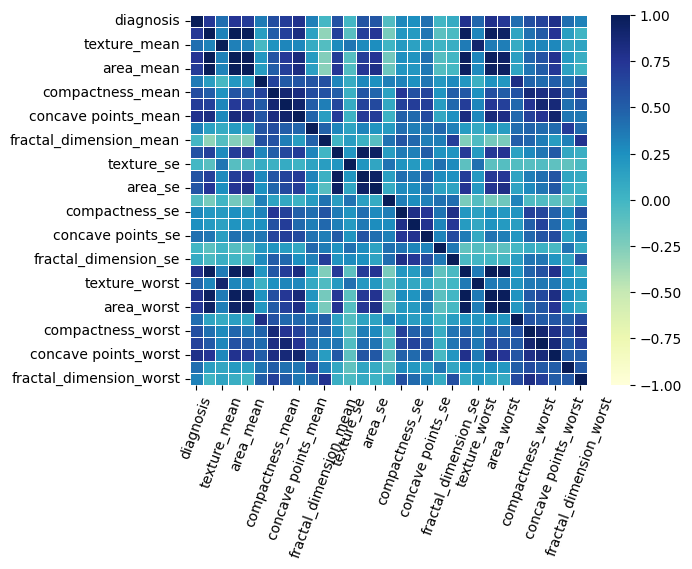

In [6]:
corr = df.corr()

ax = sns.heatmap(corr, linewidth=0.5, vmin=-1, vmax=1, cmap="YlGnBu")
plt.xticks(rotation=70)
plt.show()

### Setup Train Test Splits

In [26]:
# Select variables of interest
X = df[['radius_mean','texture_mean','perimeter_mean','area_mean',
        'smoothness_mean','compactness_mean','concavity_mean',
        'concave points_mean','symmetry_mean','fractal_dimension_mean',
        'radius_se','texture_se','perimeter_se','area_se','smoothness_se',
        'compactness_se','concavity_se','concave points_se','symmetry_se',
        'fractal_dimension_se','radius_worst','texture_worst','perimeter_worst',
        'area_worst','smoothness_worst','compactness_worst','concavity_worst',
        'concave points_worst','symmetry_worst','fractal_dimension_worst'
]].values
X = sm.add_constant(X)



# Select target
y = df['diagnosis'].values

# Setup train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

[1.000e+00 1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01
 3.001e-01 1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00
 1.534e+02 6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03
 2.538e+01 1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01
 2.654e-01 4.601e-01 1.189e-01]


### Eliminate Irrelevant Variables

Since the outcome we are predicting is a binary one, logistic regression is perfectly suited to start off. I decided to use the mlxtend library which can perform Sequential Forward Feature Selection.

In [8]:
# Perform GridSearchCV to tune best-fit LR model
param = {'C': [10**-2,10**-1,10**0,10**1,10**2]}
logisticModel = LogisticRegression(fit_intercept=True, random_state = 0,
solver='liblinear')
gs_model = GridSearchCV(estimator=logisticModel, param_grid=param)
gs_model.fit(X_train, y_train)

# Train a LR model with best parameters
model = LogisticRegression(**gs_model.best_params_, penalty='l1', solver='liblinear')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Show model coefficients and intercept.
print("Results:\n\nModel Coefficients: ")
print(model.coef_)
print("\nIntercept: ")
print(model.intercept_)

# Show confusion matrix and accuracy scores.
confusion_matrix = pd.crosstab(np.array(y_test), y_pred,
rownames = ['Actual'],
colnames = ['Predicted'])

print('\nAccuracy: ',metrics.accuracy_score(y_test, y_pred))
print("\nConfusion Matrix")
print(confusion_matrix)

print("\nClassification Report")
print(classification_report(y_test, model.predict(X_test)))

Results:

Model Coefficients: 
[[-5.78984341e+00 -7.95580181e-01 -6.11446241e-02 -9.15343045e-02
   5.18152084e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -1.29120351e+00  3.91443041e-01  1.10560877e-01  0.00000000e+00
   0.00000000e+00 -7.73064324e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.81944861e-01  3.71491583e-01 -2.39663051e-02
   1.97144345e-02  0.00000000e+00  0.00000000e+00  3.50973528e+00
   3.66817640e+01  6.88041071e+00  0.00000000e+00]]

Intercept: 
[-5.61620935]

Accuracy:  0.9649122807017544

Confusion Matrix
Predicted   0   1
Actual           
0          63   4
1           0  47

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        67
           1       0.92      1.00      0.96        47

    accuracy                           0.96       114
   macro avg       0.96      0.97      0.96       114
weighted avg

In [28]:
# Select variables of interest
X = df[['radius_mean','texture_mean','perimeter_mean','area_mean', 'smoothness_mean',
        'area_se', 'smoothness_worst', 'concave points_worst','symmetry_worst',
]].values
X = sm.add_constant(X)
print(X[0])
# Select target
y = df['diagnosis'].values

# Setup train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
print(X_test[0])

[1.000e+00 1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 1.534e+02
 1.622e-01 2.654e-01 4.601e-01]
[1.000e+00 1.340e+01 2.052e+01 8.864e+01 5.567e+02 1.106e-01 3.367e+01
 1.574e-01 2.051e-01 3.585e-01]


> Wow! It looks like Logistic Regression can do a really good job of predicting outcomes based on the included features. Looking at the model coefficients above, it seems like we can remove a good portion of the insignificant variables without affecting the efficiency and accuracy of our model

> I managed to remove all of the insignificant variables and it resulted in a 2% improvement in the model. These were the variables that I ended up with: 'radius_mean','texture_mean','perimeter_mean','area_mean', 'smoothness_mean', 'area_se', 'smoothness_worst', 'concave points_worst','symmetry_worst'

In [23]:
# Perform GridSearchCV to tune best-fit LR model
param = {'C': [10**-2,10**-1,10**0,10**1,10**2]}
logisticModel = LogisticRegression(fit_intercept=True, random_state = 0,
solver='liblinear')
gs_model = GridSearchCV(estimator=logisticModel, param_grid=param)
gs_model.fit(X_train, y_train)

# Train a LR model with best parameters
model = LogisticRegression(**gs_model.best_params_, penalty='l1', solver='liblinear')
model.fit(X_train, y_train)
print(X_test[0])
y_pred = model.predict(X_test)

# Show model coefficients and intercept.
print("Results:\n\nModel Coefficients: ")
print(model.coef_)
print("\nIntercept: ")
print(model.intercept_)

# Show confusion matrix and accuracy scores.
confusion_matrix = pd.crosstab(np.array(y_test), y_pred,
rownames = ['Actual'],
colnames = ['Predicted'])

print('\nAccuracy: ',metrics.accuracy_score(y_test, y_pred))
print("\nConfusion Matrix")
print(confusion_matrix)

print("\nClassification Report")
print(classification_report(y_test, model.predict(X_test)))

[1.000e+00 1.132e+01 2.708e+01 7.176e+01 3.957e+02 6.883e-02 8.605e+00
 9.203e-02 2.083e-02 2.849e-01]
Results:

Model Coefficients: 
[[-1.34758668e+01  3.06148731e-01  4.01701695e-01 -3.31294197e-01
   3.36221393e-02 -1.10493939e+01  1.08675244e-01  7.99860324e+01
   4.42343200e+01  1.47441202e+01]]

Intercept: 
[-12.51018586]

Accuracy:  0.9824561403508771

Confusion Matrix
Predicted   0   1
Actual           
0          74   1
1           1  38

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        75
           1       0.97      0.97      0.97        39

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



C:\Users\seany\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


> Now that we've removed 2/3 of the variables which didn't affect okur predictions as much, we've improved the model's overall performance by about 2%

> Accuracy, F1, and Precision scores all rose from about 95-96% to 98% after removing insignificant features. Now let's take a look at the distribution of the variables we have left, and whether we need to adjust for any outliers

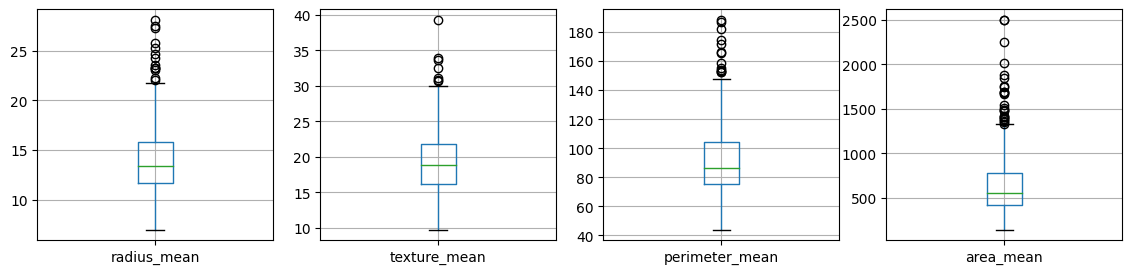

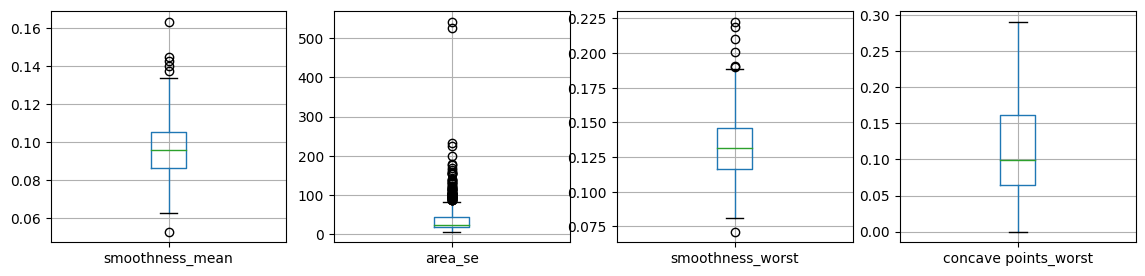

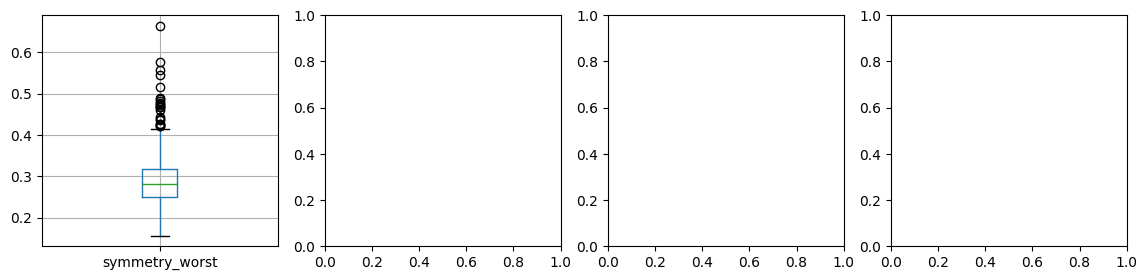

In [11]:
# Draw some subplots showing the data
plt.subplots(nrows=1, ncols=4, figsize=(14,3))
plt.subplot(1,4,1)
boxplot = df.boxplot(column=['radius_mean'])

plt.subplot(1,4,2)
boxplot = df.boxplot(column=['texture_mean'])

plt.subplot(1,4,3)
boxplot = df.boxplot(column=['perimeter_mean'])

plt.subplot(1,4,4)
boxplot = df.boxplot(column=['area_mean'])

plt.subplots(nrows=1, ncols=4, figsize=(14,3))
plt.subplot(1,4,1)
boxplot = df.boxplot(column=['smoothness_mean'])

plt.subplot(1,4,2)
boxplot = df.boxplot(column=['area_se'])

plt.subplot(1,4,3)
boxplot = df.boxplot(column=['smoothness_worst'])

plt.subplot(1,4,4)
boxplot = df.boxplot(column=['concave points_worst'])

plt.subplots(nrows=1, ncols=4, figsize=(14,3))
plt.subplot(1,4,1)
boxplot = df.boxplot(column=['symmetry_worst'])


> As you can see, there are a lot of outliers here. Originally, I meant to treat them all with KNNImputer, but I found that it didn't result in any improvements of the model

> I think this is likely due to the outliers in the above scenarios being good indicators of breast cancer. Ie. abnormal radius and mean values could indicate that something is wrong.

In [25]:
# Save the model to disk
filename = 'logRegModel.pkl'
pickle.dump(model, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
print(X_test[0])
result = loaded_model.score(X_test, y_test)
print(result)

[1.000e+00 1.340e+01 2.052e+01 8.864e+01 5.567e+02 1.106e-01 3.367e+01
 1.574e-01 2.051e-01 3.585e-01]
0.9912280701754386


### Implementing a Bagged Model

In [13]:
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

# Here we will run through evaluations of different classifiers to see which ones generate the best results.

# Create classifiers
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()
svc = SVC()
rg = RidgeClassifier()

# Build array of classifiers.
classifierArray   = [rf, et, knn, svc, rg]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

def showStats(classifier, scores):
    print(classifier + ":    ", end="")
    strMean = str(round(scores.mean(),2))

    strStd  = str(round(scores.std(),2))
    print("Mean: "  + strMean + "   ", end="")
    print("Std: " + strStd)

def evaluateModel(model, X_test, y_test, title):
    print("\n*** " + title + " ***")
    predictions = model.predict(X_test)
    accuracy    = metrics.accuracy_score(y_test, predictions)
    recall      = metrics.recall_score(y_test, predictions, average='weighted')
    precision   = metrics.precision_score(y_test, predictions, average='weighted')
    f1          = metrics.f1_score(y_test, predictions, average='weighted')

    print("Accuracy:  " + str(accuracy))
    print("Precision: " + str(precision))
    print("Recall:    " + str(recall))
    print("F1:        " + str(f1))

# # Search for the best classifier.
for clf in classifierArray:
    modelType = clf.__class__.__name__

    # Create and evaluate stand-alone model.
    clfModel    = clf.fit(X_train, y_train)
    evaluateModel(clfModel, X_test, y_test, modelType)

    # max_features means the maximum number of features to draw from X.
    # max_samples sets the percentage of available data used for fitting.
    bagging_clf = BaggingClassifier(clf, max_samples=0.4, max_features=5,
                                    n_estimators=10)
    baggedModel = bagging_clf.fit(X_train, y_train)
    evaluateModel(baggedModel, X_test, y_test, "Bagged: " + modelType)



*** RandomForestClassifier ***
Accuracy:  0.956140350877193
Precision: 0.9565611664295876
Recall:    0.956140350877193
F1:        0.9562707635625467

*** Bagged: RandomForestClassifier ***
Accuracy:  0.9736842105263158
Precision: 0.97400426742532
Recall:    0.9736842105263158
F1:        0.9737624581375282

*** ExtraTreesClassifier ***
Accuracy:  0.9824561403508771
Precision: 0.9829118250170881
Recall:    0.9824561403508771
F1:        0.9823407202216066

*** Bagged: ExtraTreesClassifier ***
Accuracy:  0.9824561403508771
Precision: 0.9829118250170881
Recall:    0.9824561403508771
F1:        0.9823407202216066

*** KNeighborsClassifier ***
Accuracy:  0.8947368421052632
Precision: 0.895800106326422
Recall:    0.8947368421052632
F1:        0.8923751686909581

*** Bagged: KNeighborsClassifier ***
Accuracy:  0.9035087719298246
Precision: 0.9064104621309371
Recall:    0.9035087719298246
F1:        0.9009032404281538

*** SVC ***
Accuracy:  0.8947368421052632
Precision: 0.9030639479022099
Reca

> From the above code, it looks like a Bagged RandomForestClassifier produces the best results. on my best run I was able to get the following scores

- Accuracy:  0.9755445544554455
- Precision: 0.9756150327845744
- Recall:    0.9755445544554455
- F1:        0.9755565893990867


In [14]:
modelType = rf.__class__.__name__

# Create and stand-alone RF model.
rfModel = rf.fit(X_train, y_train)
# evaluateModel(rfModel, X_test, y_test, modelType)

# max_features means the maximum number of features to draw from X.
# max_samples sets the percentage of available data used for fitting.
bagging_clf = BaggingClassifier(rf, max_samples=0.4, max_features=5,
                                n_estimators=10)
baggedModel = bagging_clf.fit(X_train, y_train)
evaluateModel(baggedModel, X_test, y_test, "Bagged: " + modelType)

predictions = rfModel.predict(X_test)
print(X_test[0])
print(predictions)


*** Bagged: RandomForestClassifier ***
Accuracy:  0.9649122807017544
Precision: 0.9649122807017544
Recall:    0.9649122807017544
F1:        0.9649122807017544
[1.000e+00 1.132e+01 2.708e+01 7.176e+01 3.957e+02 6.883e-02 8.605e+00
 9.203e-02 2.083e-02 2.849e-01]
[0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1
 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 1 0 1 0
 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 1 0
 1 1 0]
